## Comparisons Between all the Algorithms


In [134]:
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [135]:
RADIX = "Radix"
BITONIC = "Bitonic"
QUICK = "Quicksort"
MERGE = "Merge"

MPI = "MPI"
CUDA = "CUDA"

RANDOM = "random"
SORTED = "sorted"
REVERSE = "reverse"
PERTURBED = "perturbed"

ALGORITHMS = [RADIX, MERGE]
PROGRAMMING_MODEL = [MPI, CUDA]
INPUT_TYPES = [RANDOM, SORTED, REVERSE, PERTURBED]

INPUT_TYPE = RANDOM
TIME_TYPE = "Avg time/rank"


INPUT_SIZES = [2**16, 2**18, 2**20, 2**22, 2**24, 2**26, 2**28]


In [136]:
def getFilePath(algorithm, programmingModel, inputType):
  return f"dataFiles/{programmingModel}/{algorithm}/{inputType}/*.cali"

In [137]:
# MPI
filesList = []
tks = []

for algorithm in ALGORITHMS:
  filePath = getFilePath(algorithm=algorithm, programmingModel=MPI, inputType=INPUT_TYPE)
  filesList.append(glob(filePath))


for files in filesList:
  tk = th.Thicket.from_caliperreader(files)
  tks.append(tk)

# CUDA
filesListCuda = []
tksCuda = []

for algorithm in ALGORITHMS:
  filePath = getFilePath(algorithm=algorithm, programmingModel=CUDA, inputType=INPUT_TYPE)
  filesListCuda.append(glob(filePath))

for files in filesListCuda:
  tk = th.Thicket.from_caliperreader(files)
  tksCuda.append(tk)

In [141]:
gbs = []
for tk in tks:
  gbs.append(tk.groupby("InputSize"))

gbsCuda = []
for tk in tksCuda:
  gbsCuda.append(tk.groupby("InputSize"))

7  thickets created...
{65536: <thicket.thicket.Thicket object at 0x0000017403D233D0>, 262144: <thicket.thicket.Thicket object at 0x000001740398AED0>, 1048576: <thicket.thicket.Thicket object at 0x0000017400E47F10>, 4194304: <thicket.thicket.Thicket object at 0x0000017400D72150>, 16777216: <thicket.thicket.Thicket object at 0x0000017403EBF690>, 67108864: <thicket.thicket.Thicket object at 0x0000017403AB2490>, 268435456: <thicket.thicket.Thicket object at 0x0000017403D3D1D0>}
7  thickets created...
{65536: <thicket.thicket.Thicket object at 0x0000017406566010>, 262144: <thicket.thicket.Thicket object at 0x000001740380F290>, 1048576: <thicket.thicket.Thicket object at 0x00000174041959D0>, 4194304: <thicket.thicket.Thicket object at 0x0000017403E0C950>, 16777216: <thicket.thicket.Thicket object at 0x00000174038AB350>, 67108864: <thicket.thicket.Thicket object at 0x0000017403E41A10>, 268435456: <thicket.thicket.Thicket object at 0x0000017403A27910>}
7  thickets created...
{65536: <thicket.

In [130]:

ctks = []

for gb in gbs:
  ctk = th.Thicket.concat_thickets(
    thickets=list(gb.values()),
    headers=list(gb.keys()),
    axis="columns",
    metadata_key="num_procs"
  )
  ctks.append(ctk)

In [131]:
# Clean up Data

remove_list = [("node", "")]

for inputSize in INPUT_SIZES:
  remove_list.append((inputSize, "nid"))
  remove_list.append((inputSize, "spot.channel"))
  remove_list.append((inputSize, "Total time"))

print(remove_list)
for i, ctk in enumerate(ctks):
  
  ctk.dataframe = ctk.dataframe.reset_index().drop(remove_list, axis=1)





  



[('node', ''), (65536, 'nid'), (65536, 'spot.channel'), (65536, 'Total time'), (262144, 'nid'), (262144, 'spot.channel'), (262144, 'Total time'), (1048576, 'nid'), (1048576, 'spot.channel'), (1048576, 'Total time'), (4194304, 'nid'), (4194304, 'spot.channel'), (4194304, 'Total time'), (16777216, 'nid'), (16777216, 'spot.channel'), (16777216, 'Total time'), (67108864, 'nid'), (67108864, 'spot.channel'), (67108864, 'Total time'), (268435456, 'nid'), (268435456, 'spot.channel'), (268435456, 'Total time')]


In [132]:

'''
{dataName: str}: 'main', 'comm', 'comp', etc...
returns: dictionary of collected graph of each algorithm in ALGORITHMS
'''
def collectMPIRegion(dataName):
  res = {}

  for i, ctk in enumerate(ctks):
    algoName = ALGORITHMS[i]

    val = ctk.dataframe.loc[ctk.dataframe['name'] == dataName]

    res[f"{algoName}MPI"] = val

  return res

  
res = collectMPIRegion("main")


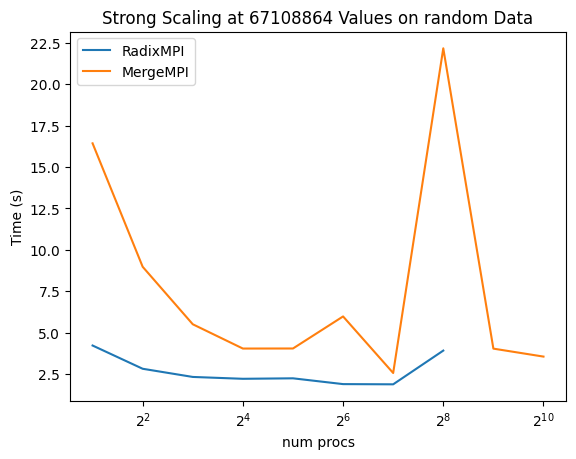

In [124]:

inputSize = INPUT_SIZES[-2]
inputType = RANDOM

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title(f"Strong Scaling at {inputSize} Values on {inputType} Data")
ax.set_xlabel("num procs")
ax.set_ylabel("Time (s)")

mainRegions = collectMPIRegion("main")
for k in mainRegions.keys():
  dframe =  mainRegions[k]
  xvals = list(dframe['num_procs'])
  yvals = list(dframe[inputSize][TIME_TYPE])
  ax.plot(xvals, yvals, label=k)

ax.legend()
plt.xscale("log", base=2)
plt.show()

  
